In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
import datetime

In [2]:
def load_data(ticker, start, end):
    df = yf.download(ticker, start=start, end=end)
    return df[['Open', 'High', 'Low', 'Close', 'Volume']]

def plot_data(data, title="Stock Price"):
    plt.figure(figsize=(10, 4))
    plt.plot(data, label='Price')
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

def preprocess_data(df, feature='Close', sequence_length=60):
    data = df[[feature]].values
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])
        y.append(scaled_data[i])

    X = np.array(X)
    y = np.array(y)
    return X.reshape((X.shape[0], X.shape[1], 1)), y, scaler

def build_model(model_type, input_shape):
    model = Sequential()
    if model_type == "LSTM":
        model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
        model.add(LSTM(50))
    elif model_type == "GRU":
        model.add(GRU(50, return_sequences=True, input_shape=input_shape))
        model.add(GRU(50))
    else:
        model.add(Dense(64, activation='relu', input_shape=input_shape))
        model.add(Dense(32, activation='relu'))

    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def forecast_next_n_days(model, last_sequence, forecast_days, scaler):
    predictions = []
    current_input = last_sequence.reshape(1, -1, 1)
    
    for _ in range(forecast_days):
        next_price = model.predict(current_input, verbose=0)[0]
        predictions.append(next_price)
        current_input = np.append(current_input[:, 1:, :], [[next_price]], axis=1)

    return scaler.inverse_transform(np.array(predictions))

In [3]:
# INPUT PARAMETERS
ticker = "AAPL"
start_date = "2015-01-01"
end_date = "2023-12-31"
chosen_feature = "Close"          # Options: Close, Open, High, Low, Volume
model_type = "LSTM"               # Options: LSTM, GRU, Dense
forecast_days = 30                # Days to forecast
sequence_length = 60              # Number of previous days to use

In [5]:
df = load_data(ticker, start_date, end_date)
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.746226,24.757334,23.848706,24.288580,212818400
2015-01-05,24.057537,24.137514,23.417722,23.604334,257142000
2015-01-06,23.668758,23.866479,23.244435,23.606554,263188400
2015-01-07,23.815388,24.037547,23.704309,23.937576,160423600
2015-01-08,24.266365,24.915067,24.148620,24.857306,237458000


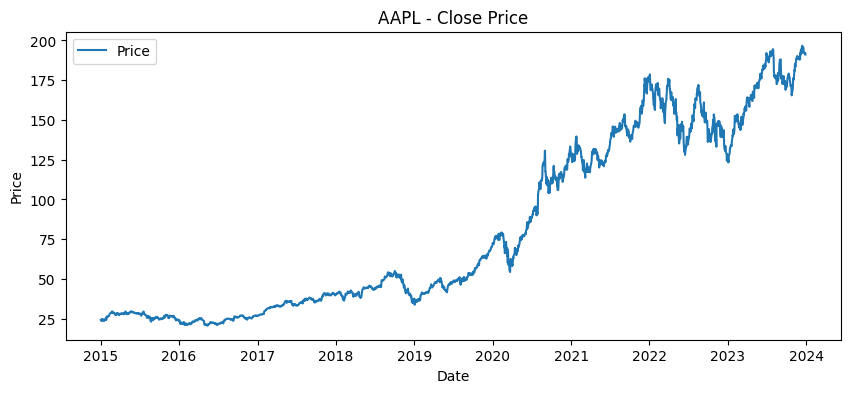

In [6]:
plot_data(df[chosen_feature], title=f"{ticker} - {chosen_feature} Price")

In [7]:
X, y, scaler = preprocess_data(df, feature=chosen_feature, sequence_length=sequence_length)

train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (1763, 60, 1)
Testing data shape: (441, 60, 1)


In [8]:
model = build_model(model_type, (X_train.shape[1], 1))
model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1)

c:\Projects\stock_price_prediction\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 0.0206
Epoch 2/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 3.8351e-04
Epoch 3/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 3.6722e-04
Epoch 4/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 4.3943e-04
Epoch 5/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 4.0982e-04


In [11]:
# Save the trained model
file_name = f"{ticker}_{model_type}_{chosen_feature}_model.h5"
model.save(file_name)

print(f"✅ Model saved as: {file_name}")

✅ Model saved as: AAPL_LSTM_Close_model.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step


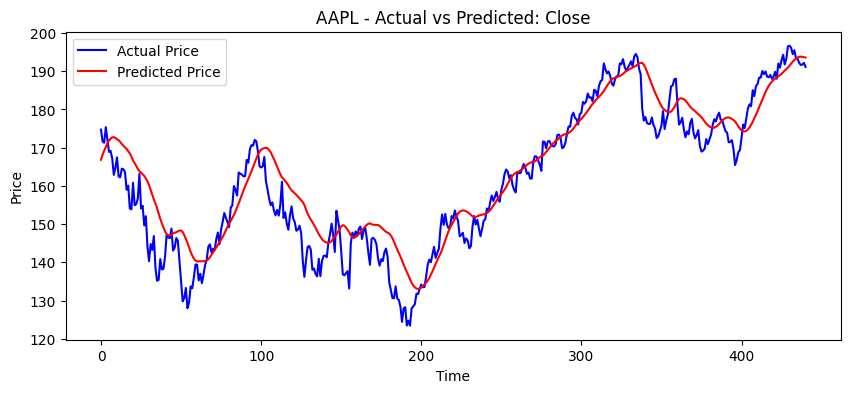

In [9]:
y_pred = model.predict(X_test)
y_pred_actual = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(10, 4))
plt.plot(y_test_actual, label='Actual Price', color='blue')
plt.plot(y_pred_actual, label='Predicted Price', color='red')
plt.title(f"{ticker} - Actual vs Predicted: {chosen_feature}")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

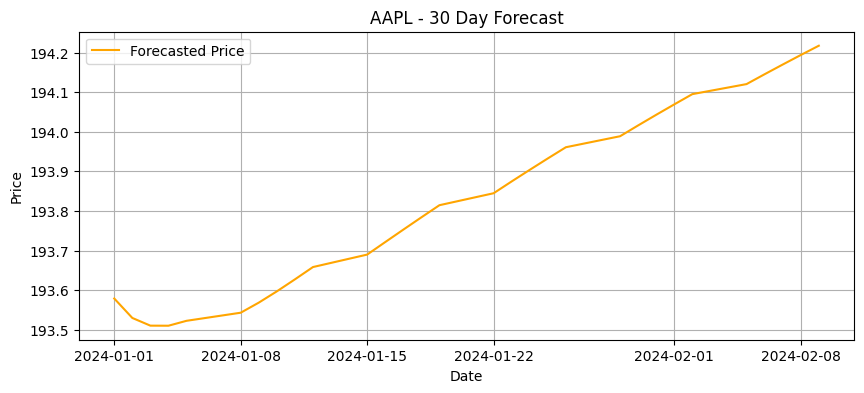

,Forecasted Price
Date,
2024-01-01,193.578812
2024-01-02,193.529709
2024-01-03,193.510269
2024-01-04,193.510086
2024-01-05,193.522491
2024-01-08,193.542953
2024-01-09,193.568405
2024-01-10,193.596893
2024-01-11,193.627182


In [10]:
last_sequence = X[-1]  # most recent input sequence
future_predictions = forecast_next_n_days(model, last_sequence, forecast_days, scaler)

# Generate future dates
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_days, freq='B')

# Plot
plt.figure(figsize=(10, 4))
plt.plot(future_dates, future_predictions, label='Forecasted Price', color='orange')
plt.title(f"{ticker} - {forecast_days} Day Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

# Show as DataFrame
pd.DataFrame({
    "Date": future_dates,
    "Forecasted Price": future_predictions.flatten()
}).set_index("Date")